# Resnet 50 dropout 0,2

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

2024-06-14 22:20:56.746747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 22:20:56.843009: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 22:20:57.226474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 22:20:58.241122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lokacija dataset-a

In [2]:
dataset_path = "../../data_set"

In [3]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [4]:
data = []
labels = []

Ucitavanje slika kroz klase


In [5]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Ucitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        img = np.stack((img,)*3, axis=-1)  # tri kanala od grayscale slike (resnet-u treba 3 kanala)
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [6]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
#data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ResNet-50 model

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


Dodavanje prilagođenih slojeva

In [10]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(len(classes), activation='softmax')(x)


In [11]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Treniranje modela

In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val))


Epoch 1/20


/home/teki/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.4058 - loss: 5.0579 - val_accuracy: 0.4216 - val_loss: 2.5284
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5107 - loss: 2.2090 - val_accuracy: 0.3310 - val_loss: 2.2081
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5510 - loss: 1.7767 - val_accuracy: 0.4111 - val_loss: 1.9324
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5505 - loss: 1.5738 - val_accuracy: 0.3432 - val_loss: 1.9072
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.5645 - loss: 1.4375 - val_accuracy: 0.4739 - val_loss: 1.4591
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.5698 - loss: 1.3239 - val_accuracy: 0.5209 - val_loss: 1.3833
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.5573 - loss: 1.2756 - val_accuracy: 0.3746 - val_loss: 1.5875
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5847 - loss: 1.2188 - val_accuracy: 0.6098 - val_loss: 1.

Evaluacija modela na test skupu


In [13]:
test_data = []
test_labels = []

In [14]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
        test_labels.append(classes.index(class_name))

In [15]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

In [22]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

2024-06-14 23:26:47.064321: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382449152 exceeds 10% of free system memory.


Classification report

In [21]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.28      0.64      0.39       115
        no_tumor       0.37      0.38      0.38       105
 pituitary_tumor       0.54      0.19      0.28        74

        accuracy                           0.32       394
       macro avg       0.30      0.30      0.26       394
    weighted avg       0.28      0.32      0.27       394



/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teki/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Preciznost je niska za sve klase, posebno za glioma tumore gde je preciznost nula, što znači da model često daje pogrešne pozitivne predikcije ili ne daje pozitivne predikcije uopšte.

Odziv je relativno viši za meningioma tumore, ali je vrlo nizak za glioma tumore i pituitary tumore, što znači da model propušta veliki broj stvarnih slučajeva ovih tumora.

F1-score vrednosti pokazuju da model ima slabe performanse za sve klase, posebno za glioma tumore, gde su potrebna značajna poboljšanja.

Ukupna tačnost modela je 32%, što je vrlo nisko, i postoji prostor za značajno poboljšanje u detekciji svih vrsta tumora.

Čuvanje rezultata


In [23]:
results = {
    "Model": ["ResNet50"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [24]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_resnet50.csv", index=False)
print(results_df)

      Model  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  \
0  ResNet50    2.641605        0.383275         2.638693             0.393728   

   Test Loss  Test Accuracy  
0   3.906302       0.324873  


Graficki prikaz rezultata

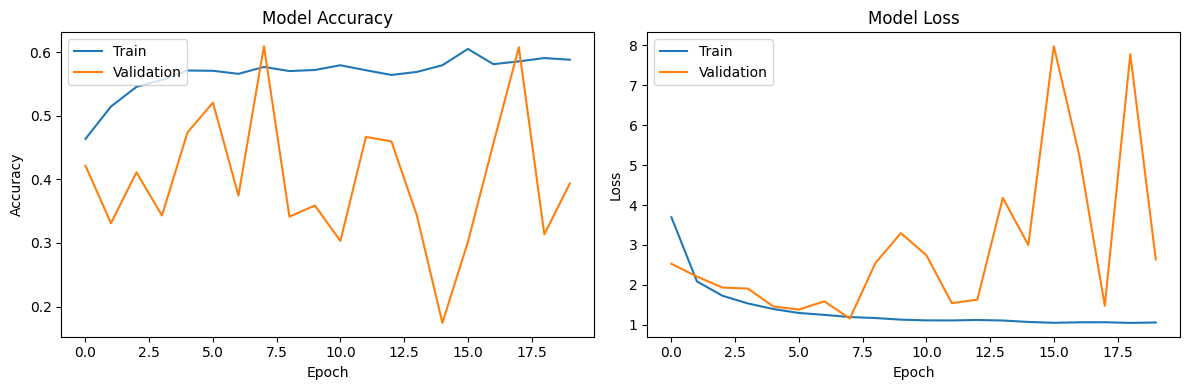

: 

In [25]:
# train history
plt.figure(figsize=(12, 4))

# Plot training, validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training, validation
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Accuracy**

Tacnost na trening skupu postepeno raste i dostize maksimalnu vrednost od oko 0.6. acnost na validacionom skupu osciluje i pokazuje nestabilnost, ali se kreće oko 0.4. Ovo ukazuje na to da model ima problema sa generalizacijom i da postoji značajna razlika između trening i validacionih performansi, što može biti znak preprilagodjavanja

**Loss**

Greska na trening setu opada tokom prvih nekoliko epoha i nastavlja da opada, dostizuci vrednosti ispod 1. Greska na validacionom skupu takođe pokazuje pad, ali sa značajnim oscilacijama. Nakon početnog pada, validaciona greška ostaje viša i nestabilnija u poređenju sa trening greškom, što ukazuje na to da model možda nije u stanju da uči relevantne karakteristike podataka dovoljno dobro, što je još jedan znak mogućeg preprilagodjavanja

Jedan od mogućih razloga za loše performanse je što poslednji slojevi ResNet mreže nisu odmrznuti za fine tuning.